# QDL 튜토리얼

이 노트북은 KAIST `고급금융계량분석` 과제(FF5 + Momentum + STR 팩터 복제)를 위한 사용 예시를 제공합니다. 과제 요구사항은 `docs/assignment_ff5.md` 를 참고하십시오. 여기서는 공개 메서드만 사용하며, 내부 구현 세부는 다루지 않습니다.

구성:
- 시작하기
- `load_factor_dataset` 로 장형(long) 팩터 데이터 로드 및 미리보기
- `transformer.to_wide_factors` 로 와이드 변환 미리보기
- `load_factors` 로 선택 팩터만 와이드로 직접 로드
- 간단 검증 데모: 노이즈 추가 → 교집합 정렬 → 지표/플롯 확인
- `load_char_dataset`/`load_char` 로 특성 데이터(장형/단일 특성 와이드) 미리보기



In [9]:
from qdl import transformer
from qdl.facade import QDL

q = QDL()
# 퍼사드로 장형 팩터 데이터 로드 후 미리보기
df_long = q.load_factor_dataset(
    country="usa",
    dataset="factor",
    weighting="vw",
    columns=["date", "name", "ret"],
)
print("장형 팩터 데이터 (상위 5행):")
print(df_long.head(5))


장형 팩터 데이터 (상위 5행):
        date name       ret
0 1926-03-31  age -0.098837
1 1926-04-30  age -0.006303
2 1926-05-31  age -0.000190
3 1926-06-30  age -0.008323
4 1926-07-31  age -0.004220


In [10]:
# 와이드 포맷으로 피벗(날짜 인덱스, 팩터명 컬럼)
wide = transformer.to_wide_factors(df_long)
print("\n와이드 팩터 데이터 (상위 5행):")
print(wide.head(5))



와이드 팩터 데이터 (상위 5행):
                 age  aliq_at  aliq_mat  ami_126d  at_be  at_gr1  at_me  \
date                                                                      
1926-01-31       NaN      NaN       NaN       NaN    NaN     NaN    NaN   
1926-02-28       NaN      NaN       NaN       NaN    NaN     NaN    NaN   
1926-03-31 -0.098837      NaN       NaN       NaN    NaN     NaN    NaN   
1926-04-30 -0.006303      NaN       NaN -0.003724    NaN     NaN    NaN   
1926-05-31 -0.000190      NaN       NaN -0.005195    NaN     NaN    NaN   

            at_turnover  be_gr1a  be_me  ...  taccruals_at  taccruals_ni  \
date                                     ...                               
1926-01-31          NaN      NaN    NaN  ...           NaN           NaN   
1926-02-28          NaN      NaN    NaN  ...           NaN           NaN   
1926-03-31          NaN      NaN    NaN  ...           NaN           NaN   
1926-04-30          NaN      NaN    NaN  ...           NaN           NaN 

In [11]:
# 퍼사드로 선택 팩터만 와이드로 직접 로드
selected_factors = ["qmj", "sale_gr1", "ivol_ff3_21d", "cash_at", "be_me"]
wide2 = q.load_factors(
    country="usa",
    dataset="factor",
    weighting="vw",
    factors=selected_factors,
    strict=False,
)
print("\n선택 팩터 와이드 데이터 (상위 5행):")
print(wide2.tail(5))



선택 팩터 와이드 데이터 (상위 5행):
                 qmj  sale_gr1  ivol_ff3_21d   cash_at     be_me
date                                                            
2024-08-31  0.016575 -0.029882      0.015226 -0.018877 -0.015909
2024-09-30  0.005974  0.001592     -0.012702  0.007899 -0.017674
2024-10-31 -0.008899 -0.038498      0.005648  0.012015  0.005687
2024-11-30 -0.019643 -0.019989     -0.053289  0.020757  0.010679
2024-12-31  0.051273 -0.030183     -0.004048  0.071257 -0.060991


In [12]:
# 간단 검증: 인덱스/열 교집합 정렬 + 비교(테스트 코드와 동일)
# 데모용 정규 잡음 추가(±0.1 클립)
import numpy as np
rng = np.random.default_rng(42)
noise = rng.normal(loc=0.0, scale=0.02, size=wide2.shape)
noise = np.clip(noise, -0.1, 0.1)
noisy_wide2 = wide2.add(noise, fill_value=0.0)

# 사용자/레퍼런스 기간 일부 차이
user_wide = noisy_wide2.iloc[12:].copy()
ref_wide = wide2.iloc[:-6].copy()

common_idx = user_wide.index.intersection(ref_wide.index)
common_cols = user_wide.columns.intersection(ref_wide.columns)
user_aligned = user_wide.loc[common_idx, common_cols]
ref_aligned = ref_wide.loc[common_idx, common_cols]

print("\n검증(인덱스 내부 조인) 기간:", common_idx.min(), "~", common_idx.max())
print("정렬된 길이:", len(common_idx))
print("열 집합 동일 여부:", set(user_aligned.columns) == set(ref_aligned.columns))



검증(인덱스 내부 조인) 기간: 1927-01-31 00:00:00 ~ 2024-06-30 00:00:00
정렬된 길이: 1170
열 집합 동일 여부: True



검증 리포트:
관측치수: 4341 시작일: 1950-11-30 00:00:00 종료일: 2024-06-30 00:00:00
mse: 0.00040107662895932965 rmse: 0.020026897636911456 mae: 0.015894341686499915 corr: 0.8579712135644002


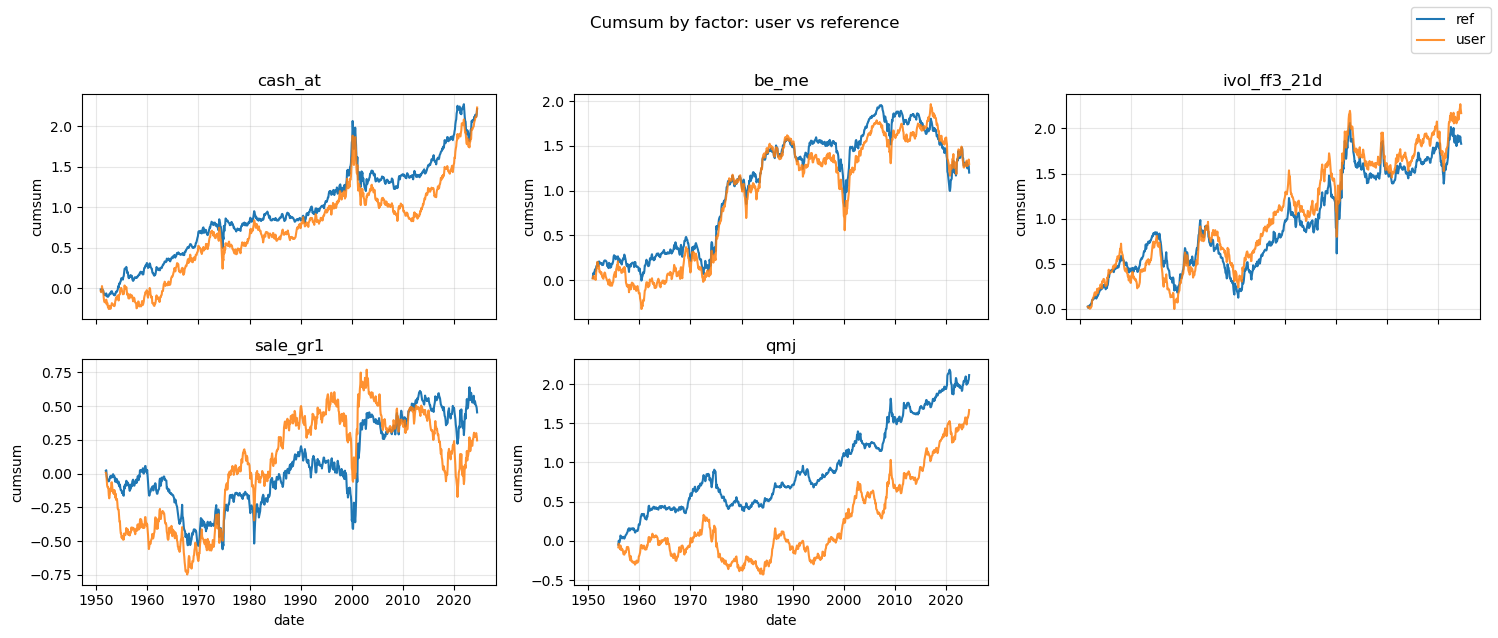

In [ ]:
# 검증 데모: 팩터별 cumsum 그래프 (옵션)
from qdl.facade import QDL
import pandas as pd

# 정렬된 와이드를 롱으로 변환
user_long = user_aligned.stack().reset_index()
user_long.columns = ["date", "name", "ret"]
ref_long = ref_aligned.stack().reset_index()
ref_long.columns = ["date", "name", "ret"]

q = QDL()
report = q.validate_factor(
    user_df=user_long,
    reference_df=ref_long,
    on=["date", "name"],
    value_col="ret",
    return_plot=True,
    plot_title="Cumsum by factor: user vs reference",
    max_plot_factors=12,
)
print("\n검증 리포트:")
print("관측치수:", report.n_obs, "시작일:", report.date_start, "종료일:", report.date_end)
print("mse:", report.mse, "rmse:", report.rmse, "mae:", report.mae, "corr:", report.corr)

# 팩터별 지표를 플롯 전에 출력
if report.per_factor_metrics:
    print("\n팩터별 지표:")
    for factor, metrics in report.per_factor_metrics.items():
        n = (report.per_factor_n_obs or {}).get(factor)
        mse = metrics.get("mse")
        rmse = metrics.get("rmse")
        mae = metrics.get("mae")
        corr = metrics.get("corr")
        ic = metrics.get("ic")
        print(
            f"{factor}: 관측치수={n}, mse={mse}, rmse={rmse}, mae={mae}, corr={corr}, ic={ic}"
        )

try:
    import matplotlib.pyplot as plt
    if report.figure is not None:
        plt.show(report.figure)
except Exception:
    pass



In [14]:
# 특성(Chars) 데모: 데이터셋과 단일 특성 와이드
# 데이터셋(장형)
chars_ds = q.load_char_dataset(
    country="usa",
    vintage="2020-",
    columns=["date", "id", "me", "be_me"],
)
print("\n특성 데이터셋 (상위 5행):")
print(chars_ds.head(5))

# 단일 특성 와이드(날짜 인덱스, id 컬럼)
wide_char_me = q.load_char(
    country="usa",
    vintage="2020-",
    char="me",
)
print("\n와이드 특성 'me' (상위 5행):")
print(wide_char_me.head(5))




특성 데이터셋 (상위 5행):
        date       id          me  be_me
0 2021-04-30  20964.0  371.249986    NaN
1 2021-05-28  20964.0  338.100007    NaN
2 2021-06-30  20964.0  336.375000    NaN
3 2021-07-30  20964.0  337.409991    NaN
4 2021-08-31  20964.0  336.375000    NaN

와이드 특성 'me' (상위 5행):
            10026.0      10028.0      10032.0      10044.0      10051.0      \
date                                                                          
2020-01-06          NaN          NaN          NaN          NaN          NaN   
2020-01-09          NaN          NaN          NaN          NaN          NaN   
2020-01-17          NaN          NaN          NaN          NaN          NaN   
2020-01-23          NaN          NaN          NaN          NaN          NaN   
2020-01-24          NaN          NaN          NaN          NaN          NaN   

            10066.0      10104.0      10107.0      10138.0      10145.0      \
date                                                                          
20

In [15]:
# Load characteristics (JKP) with strict column selection
from qdl.facade import QDL

q = QDL()
chars = q.load_chars(
    country="usa",
    vintage="2020-",
    columns=["permno", "me", "be_me"],
)
print("\nChars head (strict columns):")
print(chars.head(5))



Chars head (strict columns):
    permno          me  be_me       date       id
0  20964.0  371.249986    NaN 2021-04-30  20964.0
1  20964.0  338.100007    NaN 2021-05-28  20964.0
2  20964.0  336.375000    NaN 2021-06-30  20964.0
3  20964.0  337.409991    NaN 2021-07-30  20964.0
4  20964.0  336.375000    NaN 2021-08-31  20964.0


## 참고

- 이 노트북은 간단한 사용 예시만 제공합니다.
- 세부 규칙(정렬 기준, 가중 방식, 재구성 주기 등)은 과제 문서를 참고하세요.
- 코드 예시는 공개 메서드만 사용합니다.
